In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [3]:
cow_df = pd.read_csv("2013~2023 한우 소매가격.csv")

In [4]:
cow_df

,일자,1등급 소매가격,cpi,1
0,13-Jan,"61,860",92.728,"66,711.24"
1,13-Feb,"61,760",93.038,"66,381.48"
2,13-Mar,"58,220",92.952,"62,634.48"
3,13-Apr,"58,570",92.823,"63,098.59"
4,13-May,"59,750",92.823,"64,369.82"
...,...,...,...,...
127,23-Aug,"87,560",112.280,"77,983.61"
128,23-Sep,"92,850",112.850,"82,277.36"
129,23-Oct,"94,150",113.270,"83,119.98"
130,23-Nov,"98,360",112.680,"87,291.44"


In [5]:
# '경락일자'에서 년도와 월을 분리
cow_df['년도'] = '20' + cow_df['일자'].str.split('-').str[0]

# 월 이름을 숫자로 매핑
month_map = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}
cow_df['월'] = cow_df['일자'].str.split('-').str[1].map(month_map)

In [6]:
cow_df.head()

,일자,1등급 소매가격,cpi,1,년도,월
0,13-Jan,"61,860",92.728,"66,711.24",2013,1
1,13-Feb,"61,760",93.038,"66,381.48",2013,2
2,13-Mar,"58,220",92.952,"62,634.48",2013,3
3,13-Apr,"58,570",92.823,"63,098.59",2013,4
4,13-May,"59,750",92.823,"64,369.82",2013,5


In [7]:
cow_df['1']

0       66,711.24 
1       66,381.48 
2       62,634.48 
3       63,098.59 
4       64,369.82 
          ...     
127     77,983.61 
128     82,277.36 
129     83,119.98 
130     87,291.44 
131     83,243.15 
Name: 1, Length: 132, dtype: object

C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52860 (\N{HANGUL SYLLABLE KAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47100 (\N{HANGUL SYLLABLE REOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52628 (\

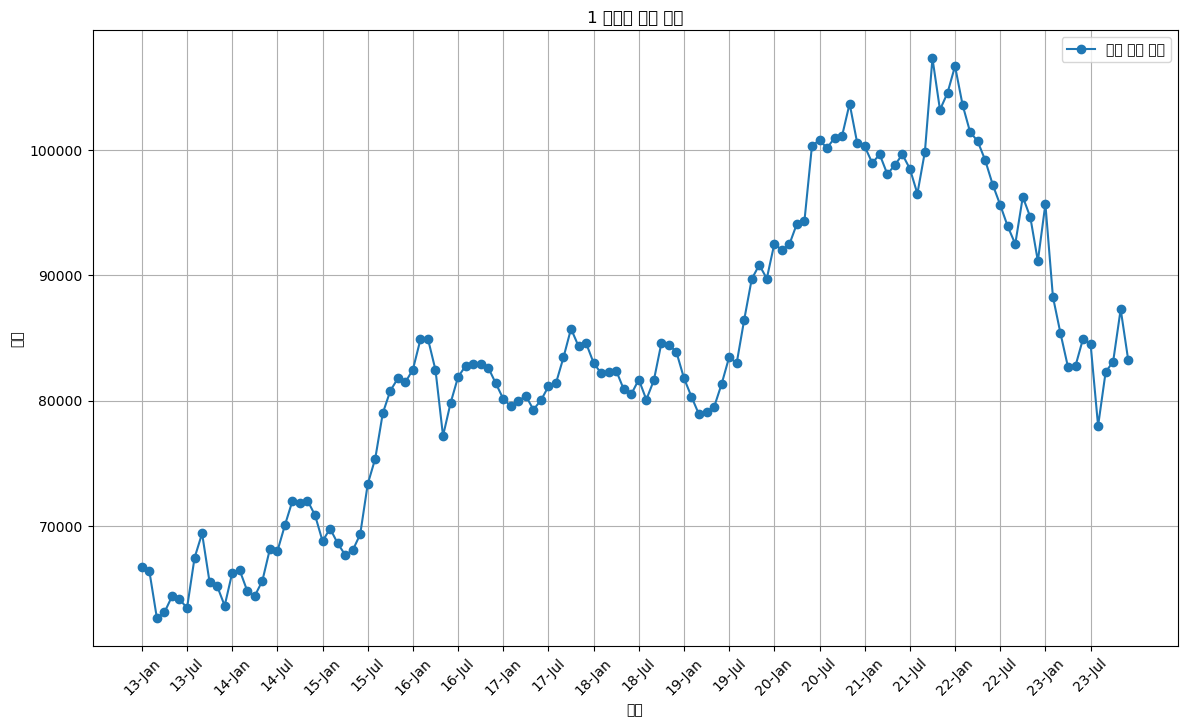

In [8]:
# '1' 칼럼의 값에서 콤마 제거 및 숫자로 변환
cow_df['1'] = cow_df['1'].str.replace(',', '').astype(float)

# 그래프 그리기
plt.figure(figsize=(14, 8))
plt.plot(cow_df['일자'], cow_df['1'], marker='o', label='조정 소매 가격')

# 라벨 및 제목 설정
plt.xlabel('일자')
plt.ylabel('가격')
plt.title('1 칼럼의 가격 추이')

# x축 레이블 간격 조정 - 필요 시 조정 가능
plt.xticks(ticks=range(0, len(cow_df['일자']), 6), rotation=45)

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

In [9]:
# ADF 검정 수행
adf_test = adfuller(cow_df['1'].dropna())

# 결과 출력
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -1.5762332702479374
p-value: 0.49552034887418195
Critical Values 1%: -3.481281802271349
Critical Values 5%: -2.883867891664528
Critical Values 10%: -2.5786771965503177


In [10]:
# 차분 필요

<Figure size 1200x600 with 0 Axes>

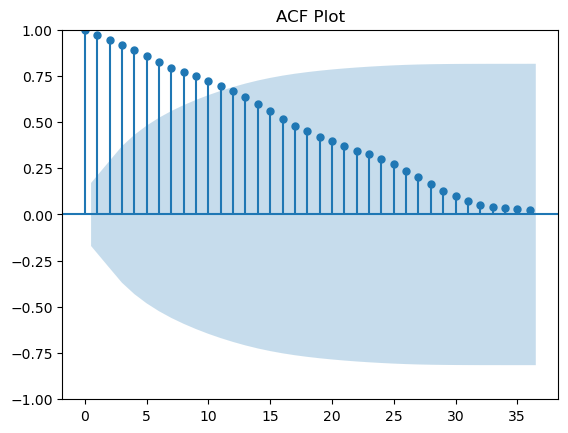

In [11]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(cow_df['1'], lags=36)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

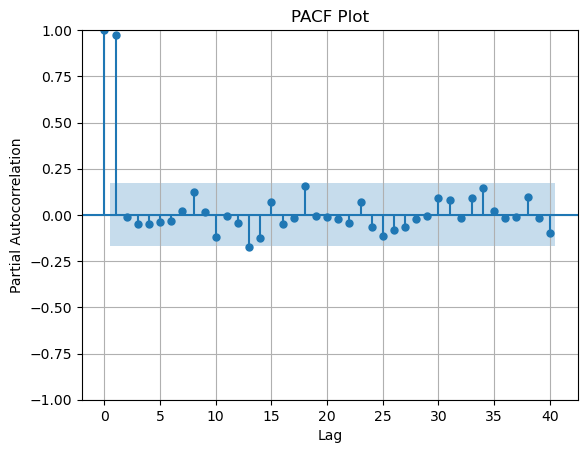

In [12]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(cow_df['1'], lags=40)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

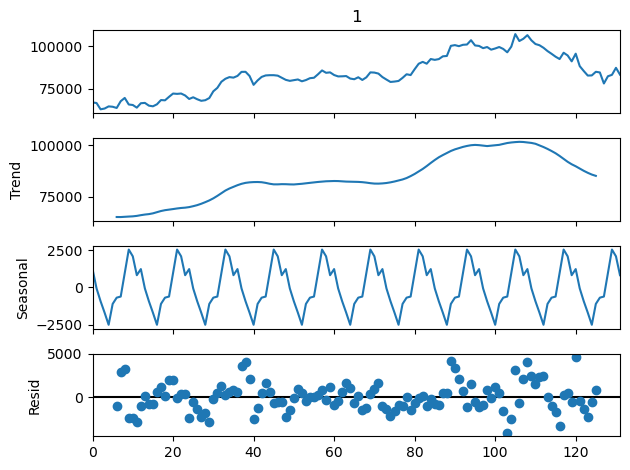

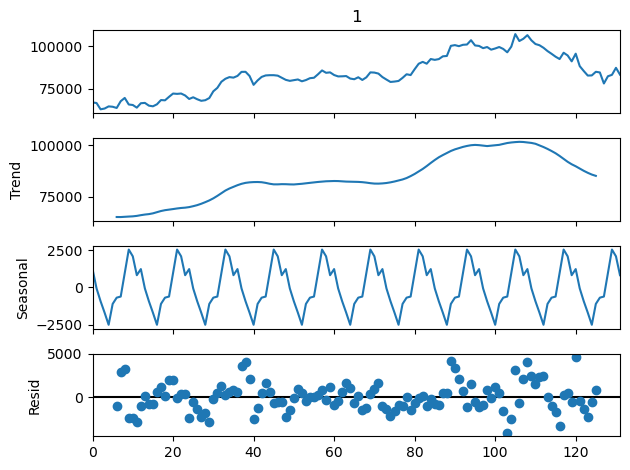

In [13]:
result = seasonal_decompose(cow_df['1'], model='additive', period=12)
result.plot()

In [14]:
# 계절성도 존재 계절 차분도 진행

In [15]:
differenced = cow_df['1'].diff().dropna()

print(differenced)

1      -329.76
2     -3747.00
3       464.11
4      1271.23
5      -212.77
        ...   
127   -6552.29
128    4293.75
129     842.62
130    4171.46
131   -4048.29
Name: 1, Length: 131, dtype: float64


In [16]:
# ADF 검정 수행
adf_test = adfuller(differenced.dropna())

# 결과 출력
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -11.305631412000471
p-value: 1.2754166676299253e-20
Critical Values 1%: -3.4816817173418295
Critical Values 5%: -2.8840418343195267
Critical Values 10%: -2.578770059171598


In [17]:
# 청탁 금지법
cow_df['년도'] = pd.to_numeric(cow_df['년도'], errors='coerce')
cow_df['월'] = pd.to_numeric(cow_df['월'], errors='coerce')
# 새로운 더미 변수 생성 (2016년 9월 이후는 1, 나머지는 0)
cow_df['SD_dummy'] = ((cow_df['년도'] > 2016) | ((cow_df['년도'] == 2016) & (cow_df['월'] >= 9))).astype(int)

# 데이터프레임의 '년도'와 '월' 열을 int로 변환
cow_df['년도'] = cow_df['년도'].astype(int)
cow_df['월'] = cow_df['월'].astype(int)

# 등급제 개편 더미 변수 추가
# 2019년 12월 이후부터 1로 설정, 그 이전은 0으로 설정
cow_df['Grade_Reform_dummy'] = cow_df.apply(lambda row: 1 if (row['년도'] > 2019 or (row['년도'] == 2019 and row['월'] >= 12)) else 0, axis=1)

# 결과 확인
print(cow_df[['일자', '년도', '월', 'Grade_Reform_dummy']].head(50))  # 상위 50개 데이터 확인

# 더미변수 생성
# 코로나19
years_of_interest = [2020, 2021, 2022]
cow_df['covid_dummy'] = cow_df['년도'].apply(lambda x: 1 if x in years_of_interest else 0)

# 구제역
# 새로운 더미 변수 초기화 (모두 0으로 설정)
cow_df['FMD_dummy'] = 0
cow_df.loc[((cow_df['년도'] == 2014) & (cow_df['월'] >= 9)) | ((cow_df['년도'] == 2015) & (cow_df['월'] <= 4)), 'FMD_dummy'] = 1


        일자    년도   월  Grade_Reform_dummy
0   13-Jan  2013   1                   0
1   13-Feb  2013   2                   0
2   13-Mar  2013   3                   0
3   13-Apr  2013   4                   0
4   13-May  2013   5                   0
5   13-Jun  2013   6                   0
6   13-Jul  2013   7                   0
7   13-Aug  2013   8                   0
8   13-Sep  2013   9                   0
9   13-Oct  2013  10                   0
10  13-Nov  2013  11                   0
11  13-Dec  2013  12                   0
12  14-Jan  2014   1                   0
13  14-Feb  2014   2                   0
14  14-Mar  2014   3                   0
15  14-Apr  2014   4                   0
16  14-May  2014   5                   0
17  14-Jun  2014   6                   0
18  14-Jul  2014   7                   0
19  14-Aug  2014   8                   0
20  14-Sep  2014   9                   0
21  14-Oct  2014  10                   0
22  14-Nov  2014  11                   0
23  14-Dec  2014

In [34]:
cow_df.head()

,일자,1등급 소매가격,cpi,1,년도,월,SD_dummy,Grade_Reform_dummy,covid_dummy,FMD_dummy
0,13-Jan,"61,860",92.728,66711.24,2013,1,0,0,0,0
1,13-Feb,"61,760",93.038,66381.48,2013,2,0,0,0,0
2,13-Mar,"58,220",92.952,62634.48,2013,3,0,0,0,0
3,13-Apr,"58,570",92.823,63098.59,2013,4,0,0,0,0
4,13-May,"59,750",92.823,64369.82,2013,5,0,0,0,0


In [108]:
# p, q, P, Q 값의 범위 설정
p = q = range(0, 3)
P = Q = range(0, 3)

# 계절 주기와 차분 차수 설정
d = 1  # 비계절 차분 차수
D = 1  # 계절 차분 차수
m = 12  # 계절 주기 (예: 12개월)
exog = cow_df[['SD_dummy','Grade_Reform_dummy','covid_dummy','FMD_dummy']]  # 원래 길이 유지

# 모든 파라미터 조합을 생성
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [m]))

# 최적의 모델을 찾기 위한 변수 초기화
aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"An error occurred for SARIMA{param}x{param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력
if best_model is not None:
    print(f'Best SARIMA model order {best_order} seasonal_order {best_seasonal_order} - AIC:{best_aic}')
    # 최적 모델의 요약 출력
    print(best_model.summary())
else:
    print("No suitable SARIMA model was found.")


Best SARIMA model order (2, 1, 2) seasonal_order (2, 1, 2, 12) - AIC:1700.9120864530769
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -837.456
Date:                            Mon, 26 Aug 2024   AIC                           1700.912
Time:                                    11:45:24   BIC                           1733.695
Sample:                                         0   HQIC                          1714.144
                                            - 132                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
SD_dummy  

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# p, q, P, Q 값의 범위 설정
p = q = range(0, 3)
P = Q = range(0, 3)

# 계절 주기와 차분 차수 설정
d = 1  # 비계절 차분 차수
D = 1  # 계절 차분 차수
m = 12  # 계절 주기 (예: 12개월)
exog = cow_df['covid_dummy']  # 원래 길이 유지

# 모든 파라미터 조합을 생성
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [m]))

# 최적의 모델을 찾기 위한 변수 초기화
aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"An error occurred for SARIMA{param}x{param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력
if best_model is not None:
    print(f'Best SARIMA model order {best_order} seasonal_order {best_seasonal_order} - AIC:{best_aic}')
    # 최적 모델의 요약 출력
    print(best_model.summary())
else:
    print("No suitable SARIMA model was found.")

Best SARIMA model order (0, 1, 2) seasonal_order (0, 1, 2, 12) - AIC:1697.6057596553762
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -842.803
Date:                            Wed, 28 Aug 2024   AIC                           1697.606
Time:                                    11:07:28   BIC                           1712.736
Sample:                                         0   HQIC                          1703.713
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy  1837.2733  

In [115]:
# p, q, P, Q 값의 범위 설정
p = q = range(0, 3)
P = Q = range(0, 3)

# 계절 주기와 차분 차수 설정
d = 1  # 비계절 차분 차수
D = 1  # 계절 차분 차수
m = 12  # 계절 주기 (예: 12개월)
exog = cow_df[['covid_dummy','SD_dummy']]  # 원래 길이 유지

# 모든 파라미터 조합을 생성
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [m]))

# 최적의 모델을 찾기 위한 변수 초기화
aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"An error occurred for SARIMA{param}x{param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력
if best_model is not None:
    print(f'Best SARIMA model order {best_order} seasonal_order {best_seasonal_order} - AIC:{best_aic}')
    # 최적 모델의 요약 출력
    print(best_model.summary())
else:
    print("No suitable SARIMA model was found.")

Best SARIMA model order (2, 1, 2) seasonal_order (2, 1, 2, 12) - AIC:1697.3564557651882
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -837.678
Date:                            Mon, 26 Aug 2024   AIC                           1697.356
Time:                                    12:37:55   BIC                           1725.096
Sample:                                         0   HQIC                          1708.552
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy  1837.2641  

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [117]:
# p, q, P, Q 값의 범위 설정
p = q = range(0, 3)
P = Q = range(0, 3)

# 계절 주기와 차분 차수 설정
d = 1  # 비계절 차분 차수
D = 1  # 계절 차분 차수
m = 12  # 계절 주기 (예: 12개월)
exog = cow_df[['covid_dummy','SD_dummy','FMD_dummy']]  # 원래 길이 유지

# 모든 파라미터 조합을 생성
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [m]))

# 최적의 모델을 찾기 위한 변수 초기화
aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"An error occurred for SARIMA{param}x{param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력
if best_model is not None:
    print(f'Best SARIMA model order {best_order} seasonal_order {best_seasonal_order} - AIC:{best_aic}')
    # 최적 모델의 요약 출력
    print(best_model.summary())
else:
    print("No suitable SARIMA model was found.")

Best SARIMA model order (2, 1, 2) seasonal_order (2, 1, 2, 12) - AIC:1698.6797877291513
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -837.340
Date:                            Mon, 26 Aug 2024   AIC                           1698.680
Time:                                    12:39:38   BIC                           1728.941
Sample:                                         0   HQIC                          1710.894
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy  1837.2667  

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# 잔차 분석

In [50]:
# 이전에 선택된 최적의 SARIMA 모델 파라미터
order = (0, 1, 2)
seasonal_order = (0, 1, 2, 12)
exog = cow_df['covid_dummy']  # 원래 길이 유지

# 모델 피팅
model = SARIMAX(cow_df['1'], 
                order=order, 
                seasonal_order=seasonal_order,
                exog=exog,
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit()

# 요약 통계 출력
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -842.803
Date:                            Tue, 27 Aug 2024   AIC                           1697.606
Time:                                    13:09:42   BIC                           1712.736
Sample:                                         0   HQIC                          1703.713
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy  1837.2733   1031.334      1.781      0.075    -184.104    3858.651
ma.L1          -0.1588      0.11

In [52]:
residuals = results.resid

C:\Users\임재성\AppData\Local\Temp\ipykernel_1364\1527678531.py:7: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
C:\Users\임재성\AppData\Local\Temp\ipykernel_1364\1527678531.py:7: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
C:\Users\임재성\AppData\Local\Temp\ipykernel_1364\1527678531.py:7: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  plt.tight_layout()
C:\Users\임재성\AppData\Local\Temp\ipykernel_1364\1527678531.py:7: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(byt

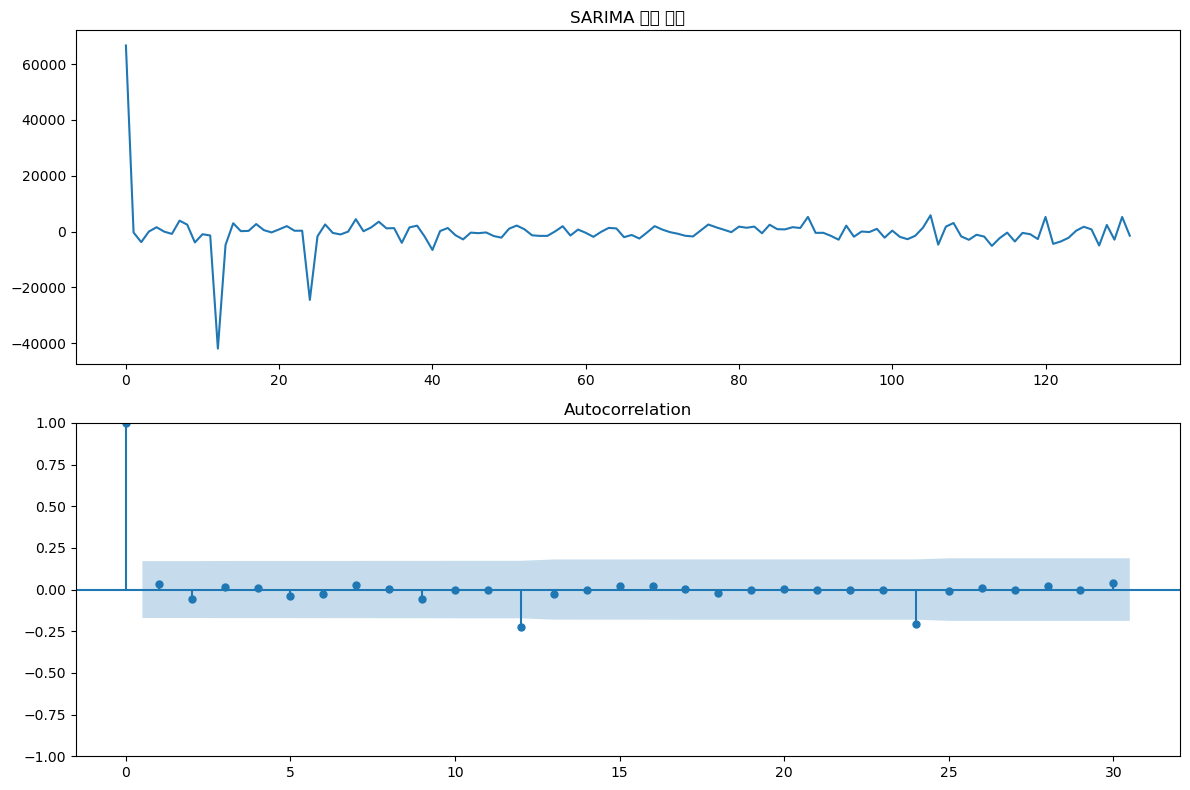

In [54]:
import statsmodels.api as sm

# 잔차 시각화
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
residuals.plot(ax=ax[0], title="SARIMA 모델 잔차")
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()


C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


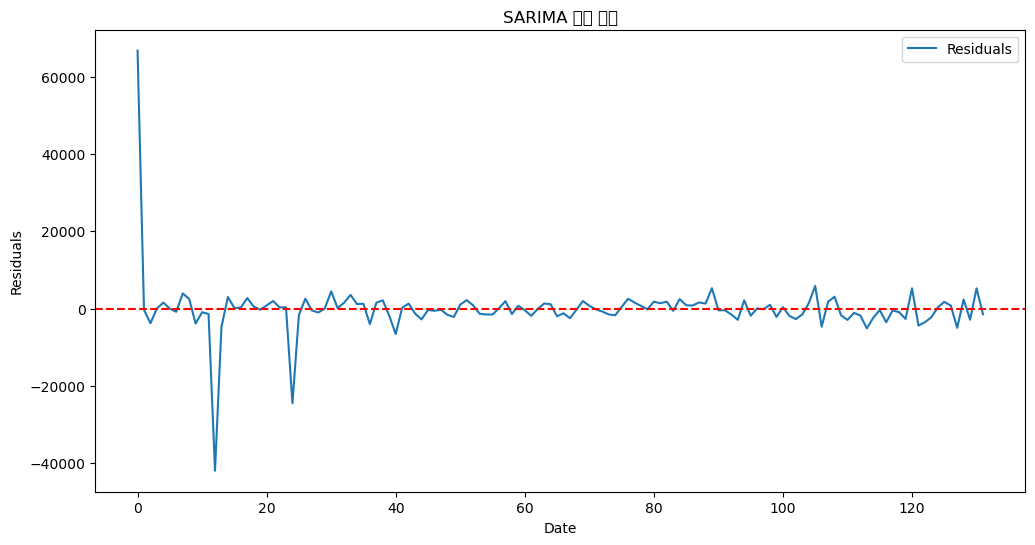

In [56]:
# 잔차 플롯을 다시 시각화하여 분산이 일정하지 않은 구간을 시각적으로 확인
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('SARIMA 모델 잔차')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [58]:
# 잔차 중 특정 임계값을 넘는 구간 추출
residual_threshold = 10000  # 임계값 설정
significant_residuals = residuals[np.abs(residuals) > residual_threshold]

significant_residuals

0     66711.240000
12   -41960.101168
24   -24496.106755
dtype: float64

In [60]:
cow_df.iloc[[12,24]]['일자']

12    14-Jan
24    15-Jan
Name: 일자, dtype: object